<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_04_04_GD_10_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

deep supervision?


https://engineer-mole.tistory.com/40

In [ ]:
#!mkdir -p /content/drive/MyDrive/aiffel/semantic_segmentation/data  

In [ ]:
#!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
#!unzip data_semantics.zip -d /content/drive/MyDrive/aiffel/semantic_segmentation/data

https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

라벨 정보를 알아보자

도로 라벨 값은 7

###데이터 로더 만들기

입력값 = 출력값 = (224,224)

로드하면서 augmentation도 같이 하자

train 일부를 val에 할당하자

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

Albumentation에서 다양한 augmentation을 확률적으로 사용하게 해주는 Compose()

imgaug의 Sometimes()와 비슷

In [ ]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:
    return Compose([
                    HorizontalFlip(p=0.5),
                    RandomSizedCrop(
                        min_max_height = (300, 370),
                        w2h_ratio = 370/1242,
                        height = 224,
                        width = 224,
                        p = 0.5
                    ),
                    Resize(
                        width = 224,
                        height = 224
                    )
    ])

  return Compose([
                  Resize(
                      width = 224,
                      height = 224
                  ) # 테스트일 때는 Resize만 수행
  ])

augment 적용 예시 보기

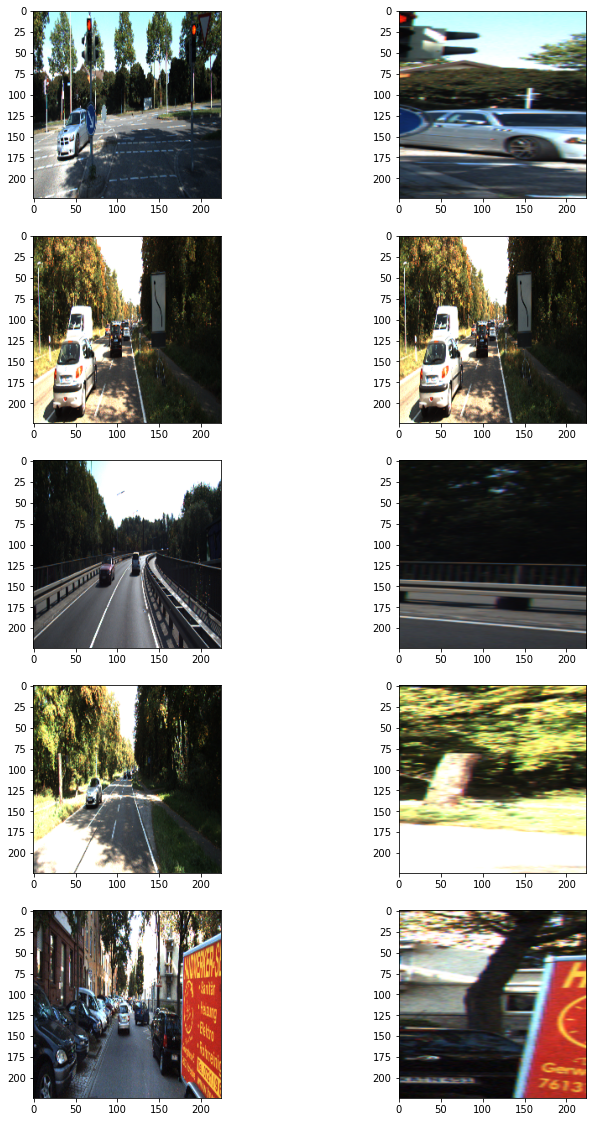

In [ ]:
dir_path = '/content/drive/MyDrive/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
augmentation_test = build_augmentation(is_train = False) #오호....
input_images = glob(os.path.join(dir_path, 'image_2', '*.png'))

#훈련 데이터 5개 뽑아서 augment 적용
plt.figure(figsize=(12,20))
for i in range(5):
  image = imread(input_images[i]) #imread 기억, skimage
  image_data = {'image':image} #딕셔너리에 'image' 로 저장
  resized = augmentation_test(**image_data) #**키워드
  processed = augmentation(**image_data)
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(resized['image']) #왼쪽 원본이미지(테스트 이미지)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(processed['image']) # 오른쪽이 augment 된 이미지

plt.show()

왜 이렇게 나올꼬..

 > augmentation_test = build_augmentation(is_train = False) 추가

###데이터셋 구성

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터 구성

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
  #kitti 데이터셋을 우리가 원하는 방식으로 preprocess 하기 위해 Sequence를 커스텀해 사용

  def __init__(self, dir_path,
               batch_size = 16, # Unet ++ > 5 굳이 2배수로 할 필욘....
               img_size = (224,224,3),
               output_size = (224,224),
               is_train=True,
               augmentation=None):

    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size #파라미터 초기화하는 과정인가

    self.data = self.load_dataset() #load_dataset을 이용해서 라벨과 이미지를 확인

# ---------------------------------------------------------------------------

  def load_dataset(self):
    #데이터셋에서 필요한 정보(이미지 경로 및 라벨)을 directory에서 확안하고 로드하는 함수입니다
    input_images = glob(os.path.join(self.dir_path,'image_2', '*.png'))
    label_images = glob(os.path.join(self.dir_path,'semantic', '*.png'))
    input_images.sort()
    label_images.sort() #이미지 라벨 순으로 혹시 모르니까
    assert len(input_images) == len(label_images)
    data = [_ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30] #train
    return data[-30:] #test

# ---------------------------------------------------------------------------

  def __len__(self):
    # generator의 length
    # 전체 데이터셋을 batch_size로 나누고 소숫점 첫째자리에서 올림
    return math.ceil(len(self.data) / self.batch_size)

# ---------------------------------------------------------------------------

  def __getitem__(self, index):
    # 입력과 출력을 만든다
    # 입력은 resize, augment가 적용된 input image이고
    # 출력은 semantic label 이다
    batch_data = self.data[
                           index*self.batch_size: #슬라이싱이었군 #배치 사이즈만큼 데이터를 나누는 과정
                           (index+1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size]) # (5,224,224,3) 0으로 세팅

    for i, data in enumerate(batch_data): #배치 속 데이터 하나하나에 뭔짓을 한다
      input_img_path, output_path = data
      _input = imread(input_img_path) #??
      _output = imread(output_path)
      _output = (_output == 7).astype(np.uint8) * 1 #라벨 7인 것만 1로
      data = {
          'image': _input,
          'mask':_output
          } #딕셔너리를 만들어서

      augmented = self.augmentation(**data) #augmentation에 딕셔너리 형태로?
      inputs[i] = augmented['image'] / 255
      outputs[i] = augmented['mask']
      return inputs, outputs

# ---------------------------------------------------------------------------

  def on_epoch_end(self): #이거 사용하나?
    # 한 에포크가 끝나면 실행되는 함수
    # 학습 중인 경우에 순서를 random shuffle 하도록
    self.indexes = np.arange(len(self.data))
    if self.is_train == True:
      np.random.shuffle(self.indexes)
      return self.indexes

    




In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train = False)

train_generator = KittiGenerator(dir_path, augmentation=augmentation)
test_generator = KittiGenerator(dir_path, augmentation= test_preproc, is_train = False)

###UNET 구현

In [ ]:
def build_model(input_shape=(224,224,3)):

  inputs = tf.keras.Input(shape = input_shape)

  x = Conv2D(1, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(inputs) #가중치 초기화
  x = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  skip_1 = x

  x = MaxPooling2D(2,2)(x)
  x = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  skip_2 = x

  x = MaxPooling2D(2,2)(x)
  x = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  skip_3 = x

  x = MaxPooling2D(2,2)(x)
  x = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  skip_4 = x
  
  x = MaxPooling2D(2,2)(x)
  x = Conv2D(1024, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(1024, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)

  x = Conv2DTranspose(512,2, strides=(2,2), padding = 'same', kernel_initializer= 'he_normal')(x)
  x = concatenate([skip_4,x], axis = 3)
  x = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(512, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)

  x = Conv2DTranspose(256,2, strides=(2,2), padding = 'same', kernel_initializer= 'he_normal')(x)
  x = concatenate([skip_3,x], axis = 3)
  x = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(256, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)

  x = Conv2DTranspose(128,2, strides=(2,2), padding = 'same', kernel_initializer= 'he_normal')(x)
  x = concatenate([skip_2,x], axis = 3)
  x = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(128, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)

  x = Conv2DTranspose(64,2, strides=(2,2), padding = 'same', kernel_initializer= 'he_normal')(x)
  x = concatenate([skip_1,x], axis = 3)
  x = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)
  x = Conv2D(2, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(x)

  outputs = Conv2D(1,1, activation='sigmoid')(x)

  model = Model(inputs = inputs, outputs = outputs)

  return model

In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 1)  28          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  640         ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

1 epoch 돌려보기

In [ ]:
'''model_path = '/content/drive/MyDrive/aiffel/semantic_segmentation/seg_model_unet.h5'

model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
    train_generator,
    validation_data = test_generator,
    steps_per_epoch = len(train_generator),
    epochs = 1
)

model.save(model_path)'''

11/11 [==============================] - 21s 617ms/step - loss: 0.6929 - val_loss: 0.6926


pretrained 모델 가져오기

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/semantic_segmentation/seg_model_unet_2.h5'
model = tf.keras.models.load_model(model_path)

###model로 inference한 결과 시각화

In [ ]:
def get_output(model, preproc, image_path, output_path):
  #image_path로 입력 이미지를 받아 preprocess 해서 model로 inference한 결과를 시각화
  #이를 output_path에 저장하는 함수

  origin_img = imread(image_path)
  data = {'image' : origin_img}
  processed = preproc(**data)

  output = model(np.expand_dims(processed['image']/255,0)) #float으로 안 나눠줘도 되낭
  output = (output[0].numpy() > 0.2).astype(np.uint8).squeeze(-1)*255 #0.5라는 threshold 변경하면 도로인식 결과 달라집
  output = Image.fromarray(output)
  background = Image.fromarray(origin_img).convert('RGBA')
  output = output.resize((origin_img.shape[1],origin_img.shape[0])).convert('RGBA') # shape과 array는 가로세로 반대다!!!
  output = Image.blend(background, output, alpha=0.5)
  
  output.save(output_path)
  output.show() # imshow가 아니네?
  return output
  

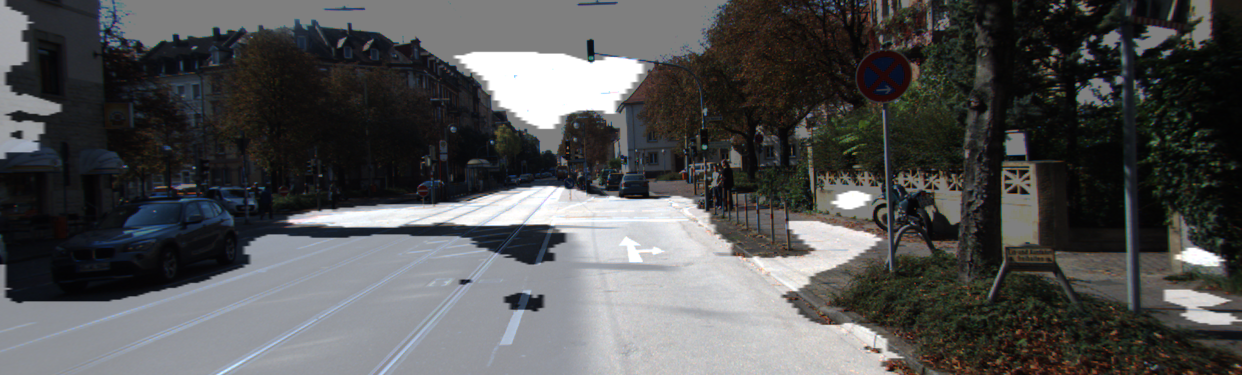

In [ ]:
i = 1
image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
output_path = dir_path + f'/result_{str(i).zfill(3)}.png'
#output_path2 = dir_path + f'./result_{str(i).zfill(3)}.png' # .이 뭐지..

get_output(
    model,
    test_preproc,
    image_path,
    output_path
    )


iou score 

In [ ]:
def calculate_iou_score(target, prediction):
  intersection = np.logical_and(target, prediction)
  union = np.logical_or(target, prediction)
  iou = float(np.sum(intersection)) / float(np.sum(union))
  print('IoU score: %f' %iou)
  return iou


prediction, target 뽑을 새로운 get_output 메서드

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
  #image_path로 입력 이미지를 받아 preprocess 해서 model로 inference한 결과를 시각화
  #이를 output_path에 저장하는 함수

  origin_img = imread(image_path)
  data = {'image' : origin_img}
  processed = preproc(**data)

  output = model(np.expand_dims(processed['image']/255,0)) #float으로 안 나눠줘도 되낭
  output = (output[0].numpy() > 0.2).astype(np.uint8).squeeze(-1)*255 #threshold 변경하면 도로인식 결과 달라짐

  prediction = output/255 #PIL 이미지 만들기 전에 pred 정의

  output = Image.fromarray(output)
  background = Image.fromarray(origin_img).convert('RGBA')
  output = output.resize((origin_img.shape[1],origin_img.shape[0])).convert('RGBA') # shape과 array는 가로세로 반대다!!!
  output = Image.blend(background, output, alpha=0.5)
  
  output.save(output_path)
  output.show() # 여기선 작동 안함

  if label_path:

    label_img = imread(label_path)
    label_data = {'image': label_img} #'label'이라고 쓰니까 에러
    processed_label = preproc(**label_data)
    processed_label = processed_label['image']
    target = (processed_label == 7).astype(np.uint8) *1 # *1은 뭐여

    return output, prediction, target
  
  else:
    return output, prediction, _ #뒤에 _ 꼭 해줘야하는겨?
  

In [ ]:
i = 1
output, prediction, target = get_output(
    model,
    test_preproc,
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path = dir_path + f'/result_{str(i).zfill(3)}.png',
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target, prediction)

IoU score: 0.757125


0.7571249090788864

###UNET++를 구현

In [ ]:
from typing_extensions import Concatenate
def build_unet_2_plus(input_shape=(224,224,3)):

  def conv2d_two(x, filters, kernel=3, activation='relu', padding = 'same', kernel_initializer='he_normal'):
    activation = 'relu'

    x = Conv2D(filters=filters, kernel_size=kernel, padding=padding, kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=filters, kernel_size=kernel, padding=padding, kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation)(x)

    return x

  def convtrans(x, filters):
    return Conv2DTranspose(filters, 2, strides=(2,2), padding = 'same', kernel_initializer= 'he_normal')(x)




  inputs = tf.keras.Input(shape = input_shape)
  x= Conv2D(1, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(inputs)

  #x_0_0
  x = conv2d_two(x, 64)
  skip_x_0 = x

  #x_1_0
  x = MaxPooling2D(2,2)(x)
  x = conv2d_two(x, 128)
  skip_x_1 = x

  #x_2_0
  x = MaxPooling2D(2,2)(x)
  x = conv2d_two(x, 256)
  skip_x_2 = x

  #x_3_0
  x = MaxPooling2D(2,2)(x)
  x = conv2d_two(x, 512)
  skip_x_3 = x

  #x_4_0
  x = MaxPooling2D(2,2)(x)
  x = conv2d_two(x, 1024)
  skip_x_4 = x

  #x_3_1
  trans = convtrans(skip_x_4, 512)
  concat = concatenate([skip_x_3, trans])
  trans = conv2d_two(concat, 512)
  skip_x_3_1 = trans

  #x_2_1
  trans = convtrans(skip_x_3, 256)
  concat = concatenate([skip_x_2, trans])
  trans = conv2d_two(concat, 256)
  skip_x_2_1 = trans

  #x_2_2
  trans = convtrans(skip_x_3_1, 256)
  concat = concatenate([skip_x_2, skip_x_2_1, trans])
  trans = conv2d_two(concat, 256)
  skip_x_2_2 = trans

  #x_1_1
  trans = convtrans(skip_x_2, 128)
  concat = concatenate([skip_x_1, trans])
  trans = conv2d_two(concat, 128)
  skip_x_1_1 = trans

  #x_1_2
  trans = convtrans(skip_x_2_1, 128)
  concat = concatenate([skip_x_1, skip_x_1_1, trans])
  trans = conv2d_two(concat, 128)
  skip_x_1_2 = trans
  
  #x_1_3
  trans = convtrans(skip_x_2_2, 128)
  concat = concatenate([skip_x_1, skip_x_1_1, skip_x_1_2, trans])
  trans = conv2d_two(concat, 128)
  skip_x_1_3 = trans

  #x_0_1
  trans = convtrans(skip_x_1, 64)
  concat = concatenate([skip_x_0, trans])
  trans = conv2d_two(concat, 64)
  skip_x_0_1 = trans

  #x_0_2
  trans = convtrans(skip_x_1_1, 64)
  concat = concatenate([skip_x_0, skip_x_0_1, trans])
  trans = conv2d_two(concat, 64)
  skip_x_0_2 = trans
  
  #x_0_3
  trans = convtrans(skip_x_1_2, 64)
  concat = concatenate([skip_x_0, skip_x_0_1, skip_x_0_2, trans])
  trans = conv2d_two(concat, 64)
  skip_x_0_3 = trans

  #x_0_4
  trans = convtrans(skip_x_1_3, 64)
  concat = concatenate([skip_x_0, skip_x_0_1, skip_x_0_2, skip_x_0_3, trans])
  trans = conv2d_two(concat, 64)
  skip_x_0_4 = trans


  #x = Conv2D(2, 3, activation='relu', padding = 'same', kernel_initializer= 'he_normal')(trans)
  outputs_1 = Conv2D(1,1, activation='sigmoid', kernel_initializer= 'he_normal', padding = 'same')(skip_x_0_1)
  outputs_2 = Conv2D(1,1, activation='sigmoid', kernel_initializer= 'he_normal', padding = 'same')(skip_x_0_2)
  outputs_3 = Conv2D(1,1, activation='sigmoid', kernel_initializer= 'he_normal', padding = 'same')(skip_x_0_3)
  outputs_4 = Conv2D(1,1, activation='sigmoid', kernel_initializer= 'he_normal', padding = 'same')(skip_x_0_4)




  model = Model(inputs = inputs, outputs = [outputs_1, outputs_2, outputs_3, outputs_4])


  return model





In [ ]:
model = build_unet_2_plus()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 224, 224, 1)  28          ['input_2[0][0]']                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 224, 224, 64  640         ['conv2d_21[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train = False)

train_generator = KittiGenerator(dir_path, augmentation=augmentation, batch_size = 5)
test_generator = KittiGenerator(dir_path, augmentation= test_preproc, is_train = False)

deep supervision - bce_dice_loss

In [ ]:
import tensorflow.keras.backend as k

flatten_layer = Flatten()

def dice_coef(y_true, y_pred):
  smooth = 1.
  y_true_f = flatten_layer(y_true)
  y_pred_f = flatten_layer(y_pred)
  intersection = k.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (k.sum(y_true_f) + k.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
  return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
  return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

###모델 학습하고 돌리고 저장

In [ ]:
'''model_path = '/content/drive/MyDrive/aiffel/semantic_segmentation/seg_model_unet++.h5'

model.compile(optimizer = Adam(1e-4), loss = bce_dice_loss)
model.fit_generator(
    train_generator,
    validation_data = test_generator,
    steps_per_epoch = len(train_generator),
    epochs = 200
)

model.save(model_path)'''

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


34/34 [==============================] - 18s 367ms/step - loss: 0.7963 - conv2d_219_loss: 0.2681 - conv2d_220_loss: 0.1660 - conv2d_221_loss: 0.2468 - conv2d_222_loss: 0.1153 - val_loss: 0.9384 - val_conv2d_219_loss: 0.2814 - val_conv2d_220_loss: 0.2061 - val_conv2d_221_loss: 0.2671 - val_conv2d_222_loss: 0.1838
Epoch 2/200
34/34 [==============================] - 12s 339ms/step - loss: 0.1352 - conv2d_219_loss: 0.1476 - conv2d_220_loss: -0.0129 - conv2d_221_loss: 0.1174 - conv2d_222_loss: -0.1169 - val_loss: 0.5672 - val_conv2d_219_loss: 0.2298 - val_conv2d_220_loss: 0.0566 - val_conv2d_221_loss: 0.2227 - val_conv2d_222_loss: 0.0581
Epoch 3/200
34/34 [==============================] - 12s 340ms/step - loss: -0.0898 - conv2d_219_loss: 0.0977 - conv2d_220_loss: -0.0719 - conv2d_221_loss: 0.0650 - conv2d_222_loss: -0.1807 - val_loss: 0.3970 - val_conv2d_219_loss: 0.1817 - val_conv2d_220_loss: 0.0130 - val_conv2d_221_loss: 0.1771 - val_conv2d_222_loss: 0.0252
Epoch 4/200
34/34 [==========

저장한 모델 불러오기

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/semantic_segmentation/seg_model_unet++.h5'
model = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss}) #커스텀 loss 가져오는 방법~


단순 이미지 결과 메서드

In [ ]:
def get_output(model, preproc, image_path, output_path, deep_supervision):
  #image_path로 입력 이미지를 받아 preprocess 해서 model로 inference한 결과를 시각화
  #이를 output_path에 저장하는 함수

  origin_img = imread(image_path)
  data = {'image' : origin_img}
  processed = preproc(**data)

  output = model(np.expand_dims(processed['image']/255,0)) #float으로 안 나눠줘도 되낭
  if deep_supervision:
    output = tf.reduce_mean(output, axis = 0)
  output = (output[0].numpy() > 0.05).astype(np.uint8).squeeze(-1)*255 #0.5라는 threshold 변경하면 도로인식 결과 달라집
  output = Image.fromarray(output)
  background = Image.fromarray(origin_img).convert('RGBA')
  output = output.resize((origin_img.shape[1],origin_img.shape[0])).convert('RGBA') # shape과 array는 가로세로 반대다!!!
  output = Image.blend(background, output, alpha=0.5)
  
  output.save(output_path)
  output.show() # imshow가 아니네?
  return output
  

이미지와 IoU 계산을 위한 메서드

In [64]:
from IPython.display import display

def get_output(model, preproc, image_path, output_path, label_path, deep_supervision):
  #image_path로 입력 이미지를 받아 preprocess 해서 model로 inference한 결과를 시각화
  #이를 output_path에 저장하는 함수

  origin_img = imread(image_path)
  data = {'image' : origin_img}
  processed = preproc(**data)

  output = model(np.expand_dims(processed['image']/255,0)) #float으로 안 나눠줘도 되낭
  if deep_supervision:
    output = tf.reduce_mean(output, axis = 0)
  output = (output[0].numpy() > 0.2).astype(np.uint8).squeeze(-1)*255 #0.5라는 threshold 변경하면 도로인식 결과 달라짐

  #prediction = output/255 #PIL 이미지 만들기 전에 pred 정의

  output = Image.fromarray(output)
  background = Image.fromarray(origin_img).convert('RGBA')
  output = output.resize((origin_img.shape[1],origin_img.shape[0])).convert('RGBA') # shape과 array는 가로세로 반대다!!!
  output = Image.blend(background, output, alpha=0.5)
  
  output.save(output_path)
  #output.show() # imshow가 아니네?
  #display(output)

  if label_path:

    label_img = imread(label_path)
    label_data = {'image': label_img} #'label'이라고 쓰니까 에러
    processed_label = preproc(**label_data)
    processed_label = processed_label['image']
    target = (processed_label == 7).astype(np.uint8) *1 # *1은 뭐여

    return output, prediction, target
  
  else:
    return output, prediction, _ #뒤에 _ 꼭 해줘야하는겨?
  

In [ ]:
i = 2
image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
output_path = dir_path + f'/result_{str(i).zfill(3)}.png'
#output_path2 = dir_path + f'./result_{str(i).zfill(3)}.png' # .이 뭐지..




UNET++ 결과

0~0.05 사이 어딘가에 threshold가 있다

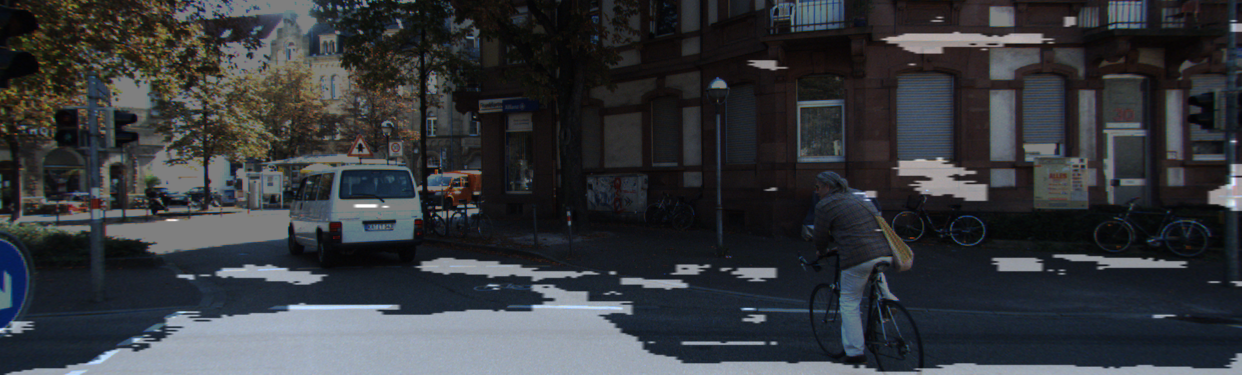

In [ ]:
get_output(
    model,
    test_preproc,
    image_path,
    output_path,
    deep_supervision=True
    )

In [59]:
i = 1
output, prediction, target = get_output(
    model,
    test_preproc,
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path = dir_path + f'/result_{str(i).zfill(3)}.png',
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
    deep_supervision=False
)

calculate_iou_score(target, prediction)

IoU score: 0.757125


0.7571249090788864

UNET 결과

In [60]:
model_path = '/content/drive/MyDrive/aiffel/semantic_segmentation/seg_model_unet_2.h5'
model = tf.keras.models.load_model(model_path)

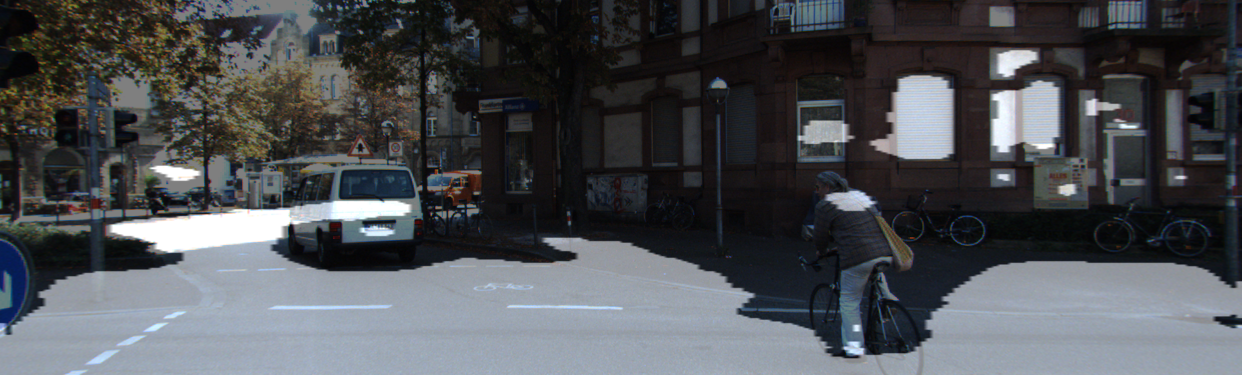

(<PIL.Image.Image image mode=RGBA size=1242x375 at 0x7F7B9C6FF8D0>,
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]),
 0.7571249090788864)

In [ ]:
get_output(
    model,
    test_preproc,
    image_path,
    output_path,
    label_path = False,
    deep_supervision=False
    )

In [ ]:
i = 1
output, prediction, target = get_output(
    model,
    test_preproc,
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path = dir_path + f'/result_{str(i).zfill(3)}.png',
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
    deep_supervision=False
)

calculate_iou_score(target, prediction)